# BTC

Projeção de pico e vale

# Import

In [1]:
# prep
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
# viz
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
#mdl
from scipy.signal import find_peaks
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

# Data

In [2]:
years = datetime.today() - timedelta(days=365 * 5)
df = yf.download(['BTC-USD'], start=years)

/tmp/ipykernel_24992/705365011.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(['BTC-USD'], start=years)
[*********************100%***********************]  1 of 1 completed


# Description

In [3]:
df.head()

Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2020-12-09,18553.916016,18626.292969,17935.546875,18320.884766,34420373071
2020-12-10,18264.992188,18553.298828,17957.064453,18553.298828,25547132265
2020-12-11,18058.904297,18268.453125,17619.533203,18263.929688,27919640985
2020-12-12,18803.656250,18919.550781,18046.041016,18051.320312,21752580802
2020-12-13,19142.382812,19381.535156,18734.332031,18806.765625,25450468637


In [4]:
df.tail()

Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2025-12-04,92141.625000,94038.242188,90976.101562,93454.257812,64538402681
2025-12-05,89387.757812,92702.640625,88152.140625,92133.648438,63256398633
2025-12-06,89272.375000,90267.460938,88951.664062,89389.359375,37994042405
2025-12-07,90405.640625,91740.843750,87799.562500,89277.812500,47394898960
2025-12-08,90975.593750,92216.906250,89726.109375,90426.945312,57409662976


In [7]:
df.shape

(1826, 5)

In [5]:
df.dtypes

,,0
Price,Ticker,
Close,BTC-USD,float64
High,BTC-USD,float64
Low,BTC-USD,float64
Open,BTC-USD,float64
Volume,BTC-USD,int64


In [6]:
df.isna().sum()

,,0
Price,Ticker,
Close,BTC-USD,0
High,BTC-USD,0
Low,BTC-USD,0
Open,BTC-USD,0
Volume,BTC-USD,0


# Preprocessing

In [3]:
df_btc = df['Close'].copy()
df_btc.columns = ['btc']

# Feature Engineering

In [4]:
# Find peaks (resistance)
peaks, _ = find_peaks(df_btc['btc'], distance=180, prominence=0.01)

resistance = df_btc['btc'].values[peaks]
resistance_idx = df_btc['btc'].index[peaks]

# Find troughs (support) by inverting the series
troughs, _ = find_peaks(-df_btc['btc'], distance=180, prominence=0.01)

support = df_btc['btc'].values[troughs]
support_idx = df_btc['btc'].index[troughs]

In [5]:
df_support = pd.DataFrame(support, index=support_idx, columns=['support'])
df_resistance = pd.DataFrame(resistance, index=resistance_idx, columns=['resistance'])
df_btc = df_btc.join(df_support).join(df_resistance).copy()

In [6]:
df_btc['support'] = df_btc['support'].interpolate()
df_btc['resistance'] = df_btc['resistance'].interpolate()

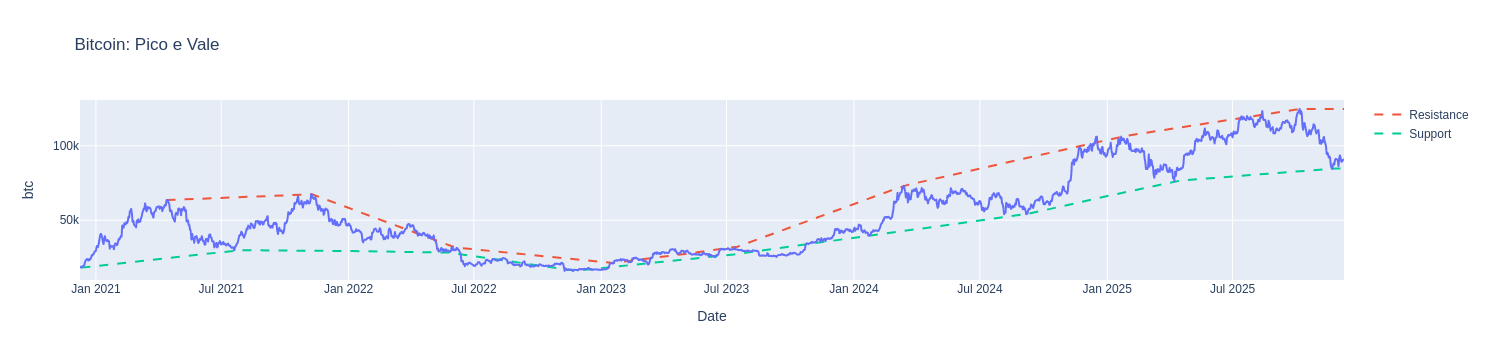

In [7]:
fig = px.line(df_btc, x=df_btc.index, y='btc', title='Bitcoin: Pico e Vale')
fig.add_trace(
    go.Scatter(
        x=df_btc.index,
        y=df_btc['resistance'],
        mode='lines',
        name='Resistance',
        line=dict(dash='dash')
    )
)

fig.add_trace(
    go.Scatter(
        x=df_btc.index,
        y=df_btc['support'],
        mode='lines',
        name='Support',
        line=dict(dash='dash')
    )
)

fig.show()

# Projeção

In [8]:
# preparação dos dados
df_support = df_btc['support'].dropna().reset_index().copy()
df_resistance = df_btc['resistance'].dropna().reset_index().copy()

df_support.rename(columns={'Date': 'ds', 'support': 'y'}, inplace=True)
df_resistance.rename(columns={'Date': 'ds', 'resistance': 'y'}, inplace=True)

In [9]:
# Ajuste do modelo
m_support = Prophet()
m_support.fit(df_support)

m_resistance = Prophet()
m_resistance.fit(df_resistance)

21:27:28 - cmdstanpy - INFO - Chain [1] start processing
21:27:29 - cmdstanpy - INFO - Chain [1] done processing
21:27:29 - cmdstanpy - INFO - Chain [1] start processing
21:27:30 - cmdstanpy - INFO - Chain [1] done processing


In [10]:
# Período de projeção
future_support = m_support.make_future_dataframe(periods=365)
future_resistance = m_resistance.make_future_dataframe(periods=365)

In [11]:
# Projeção
forecast_support = m_support.predict(future_support)
forecast_resistance = m_resistance.predict(future_resistance)

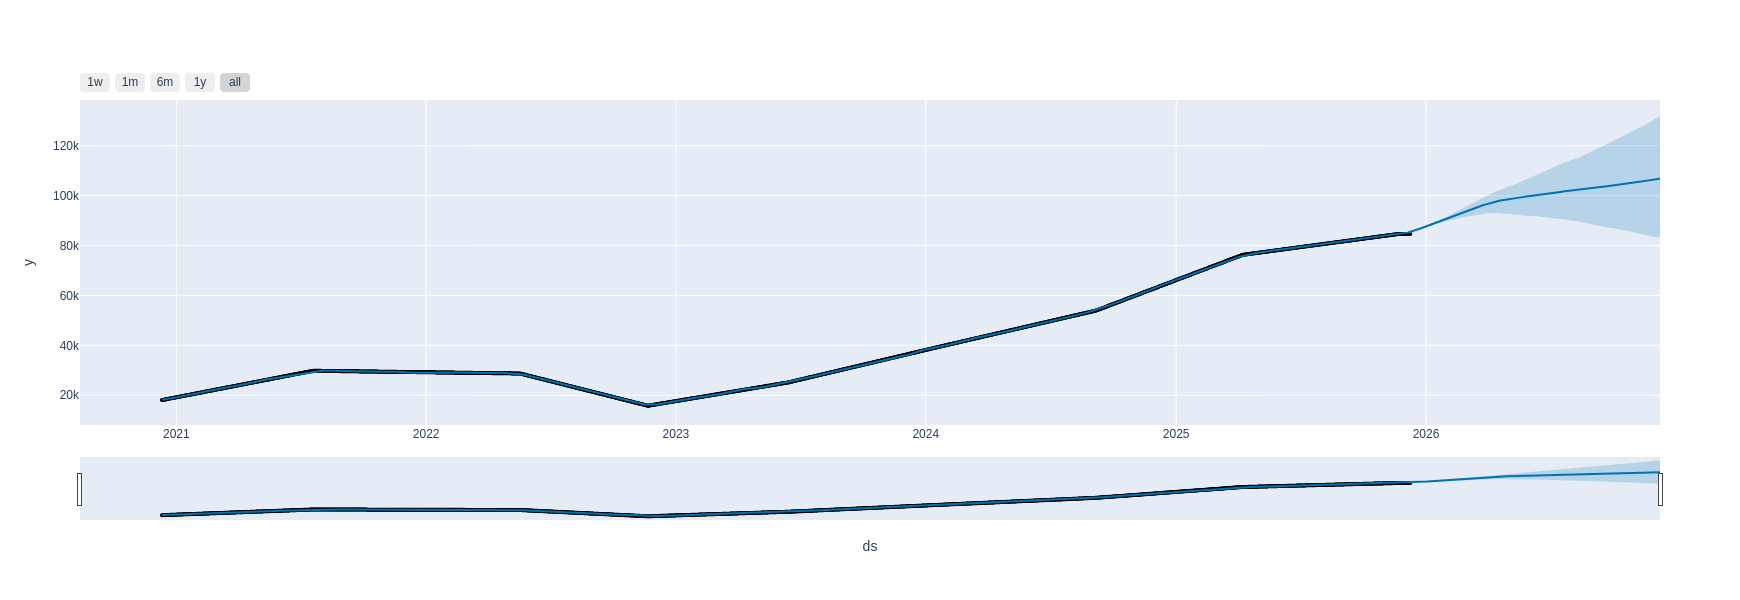

In [12]:
plot_plotly(m_support, forecast_support)

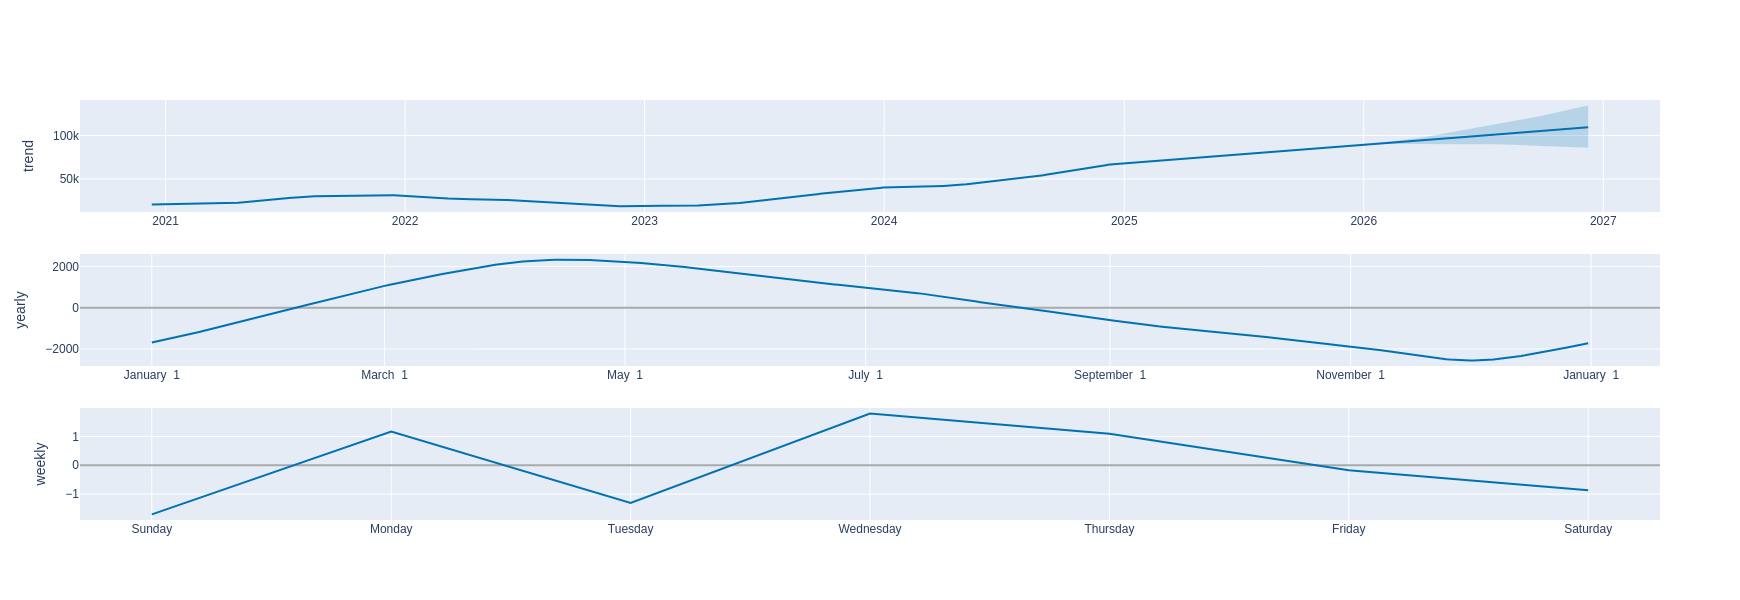

In [13]:
plot_components_plotly(m_support, forecast_support)

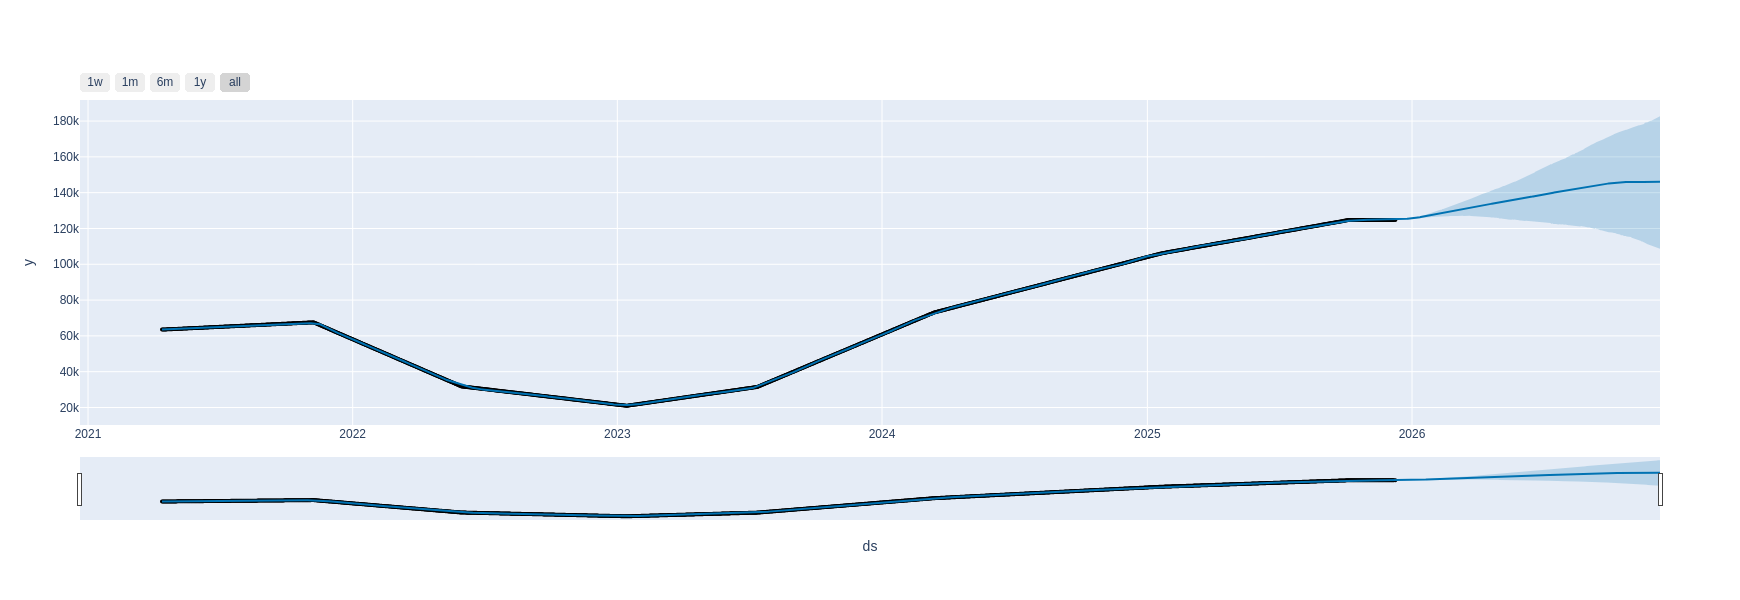

In [14]:
plot_plotly(m_resistance, forecast_resistance)

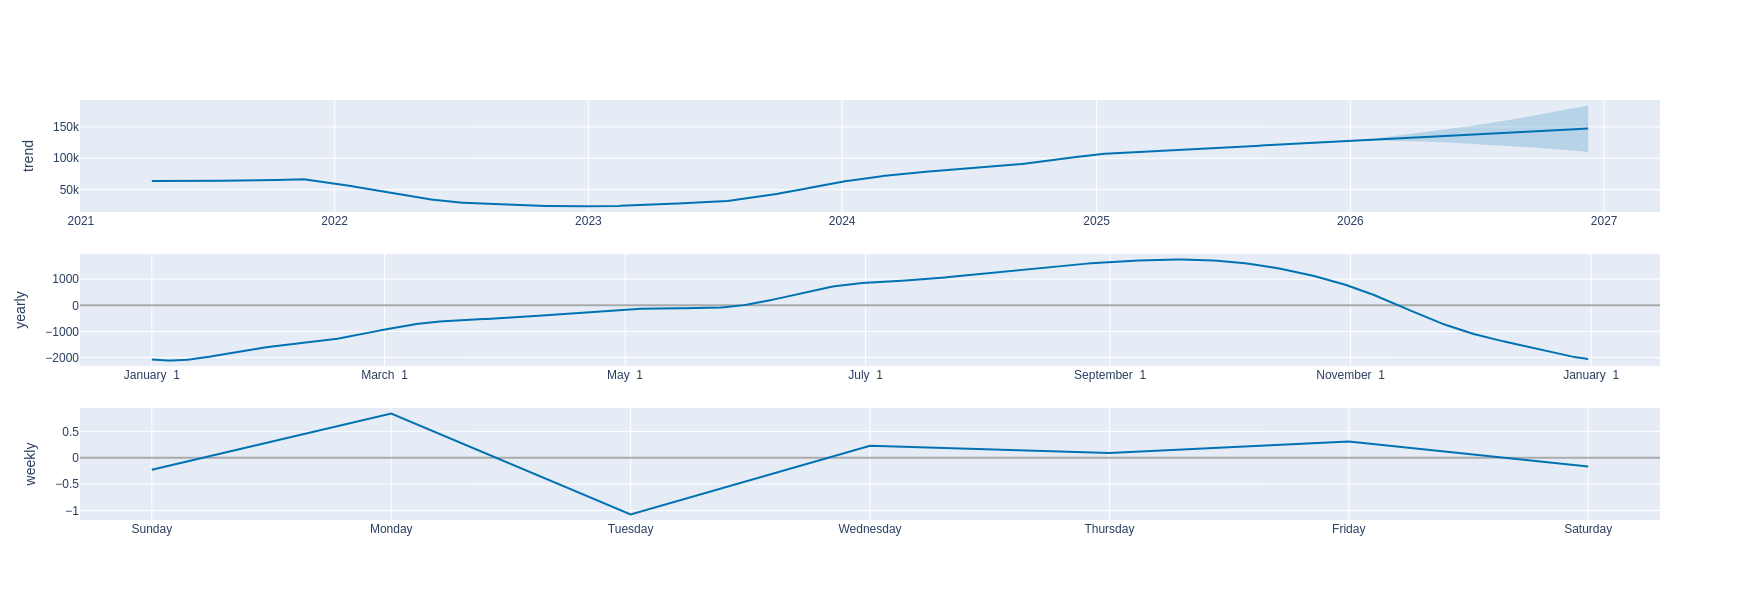

In [15]:
plot_components_plotly(m_resistance, forecast_resistance)